In [10]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
from initial_data_processing import ProcessSoccerData
pd.options.display.max_columns = 15
pd.options.display.max_colwidth = 1000

In [2]:
soccer_data = ProcessSoccerData()
df = soccer_data.get_matches_df()
# dictionary_df = soccer_data.get_dictionary_df() #seperate df for each league/season

/var/folders/1k/nj5s4vvs6b1758sjrdg0hd_40000gp/T/ipykernel_13538/523461145.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby('League')['Home_Goals', 'Away_Goals'].mean().sort_values('Home_Goals').plot(kind='barh')


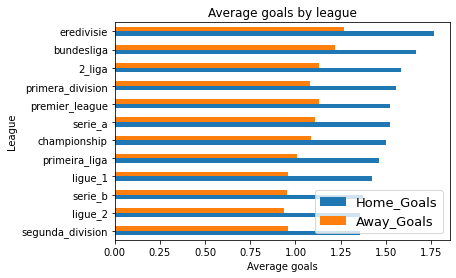

/var/folders/1k/nj5s4vvs6b1758sjrdg0hd_40000gp/T/ipykernel_13538/523461145.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby('League')['Home_Goals', 'Away_Goals'].agg(['mean','var']).plot(kind='barh', width=1, figsize=(20,10))


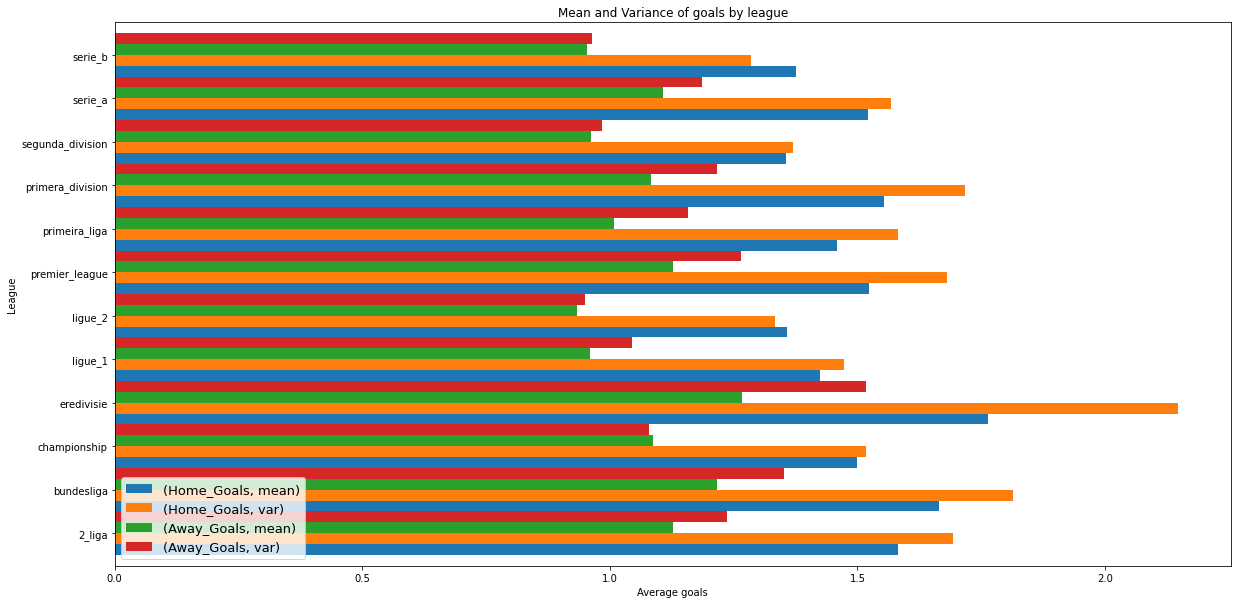

In [4]:
df.groupby('League')['Home_Goals', 'Away_Goals'].mean().sort_values('Home_Goals').plot(kind='barh')
plt.ylabel('League')
plt.xlabel('Average goals')
plt.title('Average goals by league')
leg=plt.legend(loc='lower right', fontsize=13, ncol=1)
plt.show()

df.groupby('League')['Home_Goals', 'Away_Goals'].agg(['mean','var']).plot(kind='barh', width=1, figsize=(20,10))
plt.ylabel('League')
plt.xlabel('Average goals')
plt.title('Mean and Variance of goals by league')
leg=plt.legend(loc='lower left', fontsize=13, ncol=1)
plt.show()

Looking at the data in the 2nd plot, the means and variances are similar, which would be the case if the number of home goals and number of away goals are Poisson distributed(mean=var). However, in many leagues the variance is slightly larger than the mean, which is a sign of overdispersion in the Poisson case.

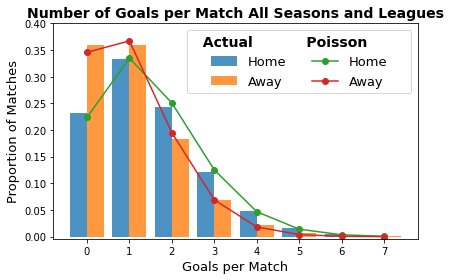

In [32]:
home_away_goals = df[['Home_Goals', 'Away_Goals']]

 # calculate Poisson probability  for home goals and away goals 
poisson_prob = np.column_stack([[poisson.pmf(i, home_away_goals.mean()[j]) for i in range(8)] for j in range(2)])

# plot histogram of actual goals
plt.hist(home_away_goals[['Home_Goals', 'Away_Goals']].values, range(9), 
         alpha=0.8, label=['Home', 'Away'],density=True, color=["steelblue", "coral"])

# add lines for the Poisson distributions
plt.plot([i-0.5 for i in range(1,9)], poisson_prob[:,0],
                  linestyle='-', marker='o',label="Home", color = 'steelblue')
plt.plot([i-0.5 for i in range(1,9)], poisson_prob[:,1],
                  linestyle='-', marker='o',label="Away", color = 'coral')


leg=plt.legend(loc='upper right', fontsize=13, ncol=2)
leg.set_title("  Actual           Poisson        ", prop = {'size':'14', 'weight':'bold'})

plt.xticks([i-0.5 for i in range(1,9)],[i for i in range(8)])
plt.xlabel("Goals per Match",size=13)
plt.ylabel("Proportion of Matches",size=13)
plt.title("Number of Goals per Match All Seasons and Leagues",size=14,fontweight='bold')
plt.ylim([-0.004, 0.4])
plt.tight_layout()
plt.show() 

In [ ]:
print(df[['Home_goals', 'Away_goals']].mean())
print(df[['Home_goals', 'Away_goals']].var())
# small overdispersion but mean approx equal to var

In [12]:
df.head()
df.shape
df.info()
df.describe().round(2)

#checking proportions
p1 = (df.Result.value_counts(normalize = True) *100).round(2).reset_index()
p1.columns = ['result', '%']
p1

p2 = (df.Match_Result.value_counts(normalize = True) *100).round(2).reset_index()
p2.columns = ['result', '%']
p2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131688 entries, 0 to 131687
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   Match_id               131688 non-null  int64 
 1   Home_Team              131688 non-null  object
 2   Away_Team              131688 non-null  object
 3   Result                 131688 non-null  object
 4   Link                   131688 non-null  object
 5   Season                 131688 non-null  int64 
 6   Round                  131688 non-null  int64 
 7   League                 131688 non-null  object
 8   Home_Goals             131688 non-null  int64 
 9   Away_Goals             131688 non-null  int64 
 10  Match_Goal_Difference  131688 non-null  int64 
 11  Match_Result           131688 non-null  object
 12  Points_Home_Team       131688 non-null  int64 
 13  Points_Away_Team       131688 non-null  int64 
dtypes: int64(8), object(6)
memory usage: 14.1+ MB


,result,%
0,H,46.28
1,D,28.37
2,A,25.34


Most of the time the home team wins as expected. 28% matches end in a draw. 

In [16]:
number_cols = df.dtypes[df.dtypes != 'object'].index.tolist()
number_cols

['Match_id',
 'Season',
 'Round',
 'Home_Goals',
 'Away_Goals',
 'Match_Goal_Difference',
 'Points_Home_Team',
 'Points_Away_Team']

In [19]:
cols_to_drop = ['Season', 'Match_id','Home_Team', 'Away_Team']

cols_for_correlation = list(set(number_cols) - set(cols_to_drop))
cols_for_correlation

['Away_Goals',
 'Points_Home_Team',
 'Points_Away_Team',
 'Match_Goal_Difference',
 'Round',
 'Home_Goals']

In [26]:

df['H_win'] = np.where(df.Match_Result == 'H', 1, 0)
df['A_win'] = np.where(df.Match_Result == 'A', 1, 0)
df['Draw'] = np.where(df.Match_Result == 'D', 1, 0)
df[cols_for_correlation + ['H_win']].corr()['H_win'].sort_values(ascending = False).reset_index()

,index,H_win
0,H_win,1.000000
1,Points_Home_Team,0.958651
2,Match_Goal_Difference,0.780709
3,Home_Goals,0.634012
4,Round,0.007264
5,Away_Goals,-0.462181
6,Points_Away_Team,-0.798053


In [30]:
df[cols_for_correlation + ['A_win']].corr()['A_win'].sort_values(ascending = False).reset_index()

,index,A_win
0,A_win,1.000000
1,Points_Away_Team,0.938465
2,Away_Goals,0.616666
3,Round,0.003711
4,Home_Goals,-0.427942
5,Match_Goal_Difference,-0.724317
6,Points_Home_Team,-0.757837


In [31]:
df[cols_for_correlation + ['Draw']].corr()['Draw'].sort_values(ascending = False).reset_index()

,index,Draw
0,Draw,1.000000
1,Round,-0.011615
2,Points_Away_Team,-0.022820
3,Away_Goals,-0.083813
4,Match_Goal_Difference,-0.164625
5,Home_Goals,-0.288337
6,Points_Home_Team,-0.329095


low correlation for draws - difficult to predict?

Now do some analyis on calculated features: 

NEED TO DO! 
    

In [ ]:

# for each feature col look at distribution see if normally dist'd 
sns.histplot(df[column]).set(ylabel = None)
